In [1]:
# Trying out the editor hypernetwork on the dune dataset
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="hypernetworks",
    config={"targetmodel": "gpt2", "editormodel": "gpt2"},
)
# Copy this below where needed!
# run.log_model(path="<path-to-model>", name="<name>")

# wandb.log({"acc": acc, "loss": loss})

# wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michaelbsklar (michaelsklar). Use `wandb login --relogin` to force relogin


In [2]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2Model
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import transformers
from tqdm import tqdm
import pandas as pd
import yaml
import contextlib
import os

In [3]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
# Set torch default device
torch.set_default_device("cuda")

In [5]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [6]:
def add_cross_attention_to_layer(block, config):
    block.crossattention = GPT2Attention(config, is_cross_attention=True)
    block.ln_cross_attn = nn.LayerNorm(
        normalized_shape=768, eps=config.layer_norm_epsilon
    )
    original_query_weights = block.attn.c_attn.weight[:, :768]
    original_keys_values = block.attn.c_attn.weight[:, 768:]
    original_query_bias = block.attn.c_attn.bias[:768]
    original_keys_values_bias = block.attn.c_attn.bias[768:]
    with torch.no_grad():
        # Initialize the new layer with these parameters
        block.crossattention.q_attn.weight = nn.Parameter(original_query_weights)
        block.crossattention.q_attn.bias = nn.Parameter(original_query_bias)
        block.crossattention.c_attn.weight = nn.Parameter(original_keys_values)
        block.crossattention.c_attn.bias = nn.Parameter(original_keys_values_bias)
    return

Now, we stick on the "reverse attention" module at the end!
This is a customized attention head that uses one BIG softmax.

In [7]:
class Reverse_Attention(nn.Module):
    def __init__(self, config):
        super().__init__()

        #Controls whether the head will do a global softmax in all positions & layers
        #If True, the attn is global and will sum to 1
        #If False, the attn is a logistic fxn independently for every layer & token
        #I suspect we will also want to penalize the intervention norm
        self.global_softmax = config.global_softmax

        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(
                torch.ones((max_positions, max_positions), dtype=torch.bool)
            ).view(1, 1, max_positions, max_positions),
            persistent=False,
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4), persistent=False)

        self.embed_dim = config.hidden_size
        # We use just a single head for now; full-dimensionality
        # self.num_reverse_heads = config.num_reverse_attention_heads
        # self.head_dim = self.embed_dim // self.num_reverse_attention_heads

        self.q_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.k_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_attn = nn.Linear(self.embed_dim, self.embed_dim)

    def _reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # The softmax is global over ALL attention!
        # This is a key difference between the forward and reverse attention
        # We also only use reverse attention from the final token of the edit sequence (last position in key)

        # Awkward error handling, because apparently, it seems like if the batch size is 1,
        # we wind up with a 3D tensor, not a 4D tensor??? Should trace this issue back!
        
        if self.global_softmax:
            if key.dim() == 4:
                K_reduced = key[
                    :, :, -1, :
                ]  # R# Check: that the second dimension of K is only a single element when we have batching
                KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
                softmaxed_weights = nn.functional.softmax(KQ_weights, dim=2)
                attn_output = torch.bmm(
                    softmaxed_weights.transpose(1, 2), value[:, :, -1, :]
                )

            if key.dim() == 3:
                QK_weights = torch.matmul(query, key.transpose(-1, -2))
                softmaxed_weights = nn.functional.softmax(QK_weights, dim=1)
                attn_output = torch.matmul(softmaxed_weights, value)

            return attn_output, softmaxed_weights

        if self.global_softmax == False:
            if key.dim() == 4:
                K_reduced = key[
                    :, :, -1, :
                ]  # R# Check: that the second dimension of K is only a single element when we have batching
                KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
                logistic_weights = torch.atan(KQ_weights)
                attn_output = torch.bmm(
                    logistic_weights.transpose(1, 2), value[:, :, -1, :]
                )

            if key.dim() == 3:
                QK_weights = torch.matmul(query, key.transpose(-1, -2))
                logistic_weights = torch.atan(QK_weights)
                attn_output = torch.matmul(logistic_weights, value)

            return attn_output, logistic_weights


    def forward(
        self,
        editor_hidden_states,
        target_hidden_states,
        attention_mask=None,
        output_attentions=False,
    ):

        # Here, the query is the target hidden encoder, the key is the editor, and the value is the editor
        query = self.q_attn(target_hidden_states)
        key = self.k_attn(
            # [:, 0, :1, :]
            editor_hidden_states[:, :1, :]
        )  # Pull only the final token position
        value = self.v_attn(
            # [:, 0, :1, :]
            editor_hidden_states[:, :1, :]
        )  # Pull only the final token position

        attn_output, attn_weights = self._reverse_attn(query, key, value)

        if output_attentions:
            return attn_output, attn_weights
        else:
            return attn_output

In [8]:
import types
from typing import Optional, Tuple, Union


def new_forward(
    self,
    input_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    token_type_ids: Optional[torch.LongTensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.Tensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    # labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple]:
    r"""
    labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
        Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
        `labels = input_ids` Indices are selected in `[-100, 0, ..., config.vocab_size]` All labels set to `-100`
        are ignored (masked), the loss is only computed for labels in `[0, ..., config.vocab_size]`
    """

    transformer_outputs = self.transformer(
        input_ids,
        past_key_values=past_key_values,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_attention_mask,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )
    hidden_states = transformer_outputs[0]

    # Set device for model parallelism
    if self.model_parallel:
        torch.cuda.set_device(self.transformer.first_device)
        hidden_states = hidden_states.to(self.lm_head.weight.device)

    # lm_logits = self.lm_head(hidden_states)
    reverse_attention_output = self.lm_head(
        hidden_states, encoder_hidden_states, output_attentions=output_attentions
    )

    return reverse_attention_output

In [9]:
def replace_linear_final_layer_with_bespoke_reverse_attention(model):
    model.lm_head = Reverse_Attention(config=model.config)
    model.forward = new_forward.__get__(model, GPT2LMHeadModel)
    return

In [10]:
@contextlib.contextmanager
def add_fwd_hooks(module_hooks):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for mod, hk in module_hooks:
            handles.append(mod.register_forward_hook(hk))
        yield
    finally:
        for h in handles:
            h.remove()

In [11]:
def assign_layer_indices(model):
    """
    Assigns a custom attribute 'layer_index' to each transformer layer in the GPT-2 model.
    This function iterates over the transformer blocks and assigns an index to each.
    """
    model.transformer.wte.layer_index = 0
    for i, layer in enumerate(model.transformer.h):
        layer.layer_index = i + 1


# Usage:
# assign_layer_indices(target_model)

In [12]:
class EditorHypernetwork(nn.Module):
    # Separating the editor config file, from its base model's configurations
    def __init__(self, 
        editor_yaml_file_path="config/editor_omniscient.yaml", 
        global_softmax=False,
        use_layerwise_embeddings=True,
        edit_dampening_factor=.001#tuning parameter to help the edits not be initialized too large
        ):

        super().__init__()

        # Construct Editor Model
        # Load the configuration from the YAML file
        # with open(editor_yaml_file_path, 'r') as file:
        #     self.config = yaml.safe_load(file)
        self.editor_model = GPT2LMHeadModel.from_pretrained(
            "gpt2"
        ).cuda().eval()  # have recently added .cuda() so it uses the gpu

        # Add cross-attention to each layer
        self.editor_model.config.add_cross_attention = True
        self.editor_model.config.global_softmax = global_softmax
        for i in range(12):
            add_cross_attention_to_layer(
                self.editor_model.transformer.h[i], self.editor_model.config
            )
        # Replace the final linear layer with special reverse attention output
        self.editor_model.lm_head = Reverse_Attention(config=self.editor_model.config)
        self.editor_model.forward = new_forward.__get__(
            self.editor_model, GPT2LMHeadModel
        )
        self.editor_model.cuda()

        # Construct Target Model
        self.target_model = transformers.AutoModelForCausalLM.from_pretrained(
            "gpt2"
        ).cuda().eval()
        for param in self.target_model.parameters():
            param.requires_grad = False
        assign_layer_indices(self.target_model)

        self.target_model.cuda()

        # Add module for layerwise embeddings
        if use_layerwise_embeddings:
            self.use_layerwise_embeddings = True
            self.layerwise_embeddings = torch.randn(13, 768, requires_grad=True).cuda()
        else:
            self.use_layerwise_embeddings = False
            self.layerwise_embeddings = 0

        self.edit_dampening_factor = edit_dampening_factor

        self.residual_cache = None
        self.opt = None
        self.lossfn = None
        self.lam = None
        self.penalty_loss= None
        self.training_loss = None

    # Gets the hidden states from the target model, if necessary
    def run_target_model_for_encoded_hidden_states(self, target_ids):
        with torch.no_grad():
            outputs = self.target_model(target_ids, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            return hidden_states

    def forward(
        self,
        editor_input_ids,
        target_input_ids,
        target_hidden_states=None,
        output_target_hidden_states=False,
        output_edited_hidden_states=False,
        output_edit_vectors=False,
        output_editor_attention=False,
        stop_editing_index=None,
        batch_edit_vectors=None,
    ):

        # Run target model for encoded hidden states
        if target_hidden_states is None:
            target_hidden_states = torch.stack(
                self.run_target_model_for_encoded_hidden_states(
                    target_input_ids.to("cuda")
                ),
                dim=2,
            )
        # dimensions of target_hidden_states:
        # batch_size, token_sequence_length, num_layers = 13, resid_width = 768

        # If we are stopping editing at stop_editing_index, then we eliminate target_hidden_states beyond that index
        if stop_editing_index is not None:
            target_hidden_states = target_hidden_states[
                :, :stop_editing_index, :, :
            ].clone()

        # Normalize along the last dimension
        normalization_factors = target_hidden_states.norm(dim=-1, keepdim=True)
        target_hidden_states = target_hidden_states / normalization_factors

        # Error catching:
        if batch_edit_vectors is not None:
            if output_edit_vectors or output_editor_attention:
                return "Error: Inputting your own batch_edit_vectors means the model does not construct the outputs you are requesting"

        # Run editor model, get edit vectors
        if batch_edit_vectors is None:
            if self.use_layerwise_embeddings:
                # Now, add in the layerwise embeddings
                embedded_hidden_states = target_hidden_states + self.layerwise_embeddings[None, None, :, :]

                collapsed_target_hidden_states = embedded_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            else:
                collapsed_target_hidden_states = target_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            
            editor_output = self.editor_model(
                editor_input_ids.to("cuda"),
                encoder_hidden_states=collapsed_target_hidden_states,
                output_attentions=output_editor_attention,
            )
            # Multiply the outputs by normalization factors
            if output_editor_attention:
                temp_edit_vectors = editor_output[0]
                # Might want to reshape this too but whatever
                batch_editor_attention = editor_output[1]
            else:
                temp_edit_vectors = editor_output
            
            #Renormalize to the scale of the target hidden states
            #and reshape to proper dimensions
            batch_edit_vectors = self.edit_dampening_factor * normalization_factors * temp_edit_vectors.reshape(
                    temp_edit_vectors.shape[0], stop_editing_index, 13, 768
                )
            
        # If we are stopping editing at stop_editing_index,
        # this pads batch_edit_vectors with 0's to the right of the edited positions
        if stop_editing_index is not None:
            batch_edit_vectors = torch.cat(
                (
                    batch_edit_vectors,
                    torch.zeros(
                        batch_edit_vectors.shape[0],
                        target_input_ids.shape[1] - stop_editing_index,
                        13,
                        768,
                    ),
                ),
                dim=1,
            )

        # Run target model with edit vectors. This adds the edit vectors to the given hidden state at the specified batch index, position, and layer
        def edit_add(module, input, output):
            layer_index = module.layer_index
            output[0][:] = output[0] + batch_edit_vectors[:, :, layer_index, :]

        def embedding_edit_add(module, input, output):
            output[:] = output + batch_edit_vectors[:, :, 0, :]

        # Now editing the target model
        hooks1 = [(self.target_model.transformer.wte, embedding_edit_add)]
        hooks2 = [(self.target_model.transformer.h[L], edit_add) for L in range(12)]
        hooks = hooks1 + hooks2
        with add_fwd_hooks(hooks):
            # THIS IS THE LINE WHERE THE MODEL IS CALLED (AND THE EDITOR IS CALLED AT
            # THE END OF `layer` AS A SIDE EFFECT)
            target_result = self.target_model(
                target_input_ids.to("cuda"),
                output_hidden_states=output_edited_hidden_states,
            )

        logits = target_result.logits

        output = {}
        output["logits"] = logits
        if output_target_hidden_states:
            output["target_hidden_states"] = (
                target_hidden_states * normalization_factors
            )
        if output_edited_hidden_states:
            output["edited_hidden_states"] = target_result.hidden_states
        if output_edit_vectors:
            output["edit_vectors"] = batch_edit_vectors
        if output_editor_attention:
            output["editor_attention"] = batch_editor_attention
        return output

    # Generate text using the target model, with a new edit application at every step.
    # This is a very slow way to generate text.
    # If you only want to edit first k tokens, use the forward pass instead with stop_editing_index = k
    def generate_with_repeated_edits(
        self, editor_input_ids, target_input_ids, max_length=10
    ):
        """Generate text using the target model, with a new edit application at every step."""
        generated_ids = target_input_ids
        for _ in range(max_length):
            # Use the target model's forward pass, which applies cached residuals
            outputs = self.forward(
                editor_input_ids=editor_input_ids.to("cuda"),
                target_input_ids=generated_ids.to("cuda"),
            )
            # Get the next token here (simplified for brevity)
            next_token_id = outputs["logits"][:, -1, :].argmax(dim=-1)
            generated_ids = torch.cat(
                (generated_ids, next_token_id.unsqueeze(-1)), dim=1
            )
        return generated_ids

    def evaluate_KL_test_loss_nogradient(self,dataloader, f_data_to_soft_labels = None, stop_editing_index=8, batch_size = 50):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_samples = 0
            for batch in dataloader:
                current_batch_size = len(batch)
                self.editor_inputs = torch.tensor(
                    dataframe["test"]["edit_tokens"][i : i + batch_size]
                ).squeeze(1)
                self.target_inputs = torch.tensor(
                    dataframe["test"]["edit_result_ids"][i : i + batch_size]
                ).squeeze(1)
                self.prediction = self.forward(
                    self.editor_inputs.to("cuda"),
                    self.target_inputs.to("cuda"),
                    stop_editing_index=stop_editing_index
                )
                log_prob_predictions = torch.nn.functional.log_softmax(
                    self.prediction["logits"][
                        :, stop_editing_index:, :
                    ].reshape(-1, 50257),
                    dim=1,
                )
                # Now we must compute the soft labels!
                soft_labels = f_data_to_soft_labels(
                    torch.tensor(
                        dataframe["test"]["edit_result_ids"][i : i + batch_size]
                    ),
                    stop_editing_index,
                )
                self.loss = torch.nn.functional.kl_div(log_prob_predictions, soft_labels, reduction = 'batchmean')
                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += self.loss.item() * current_batch_size
                total_samples += current_batch_size
            weighted_average_loss = sum_weighted_losses / total_samples
        return weighted_average_loss

        
    def evaluate_crossentropy_test_loss_nogradient(self, 
                        dataloader, 
                        stop_editing_index= 8, 
                        batch_size = 50):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_samples = 0
            for batch in dataloader:
                current_batch_size = len(batch['edit_tokens'])
                # self.editor_inputs = torch.tensor(
                #     dataframe["test"]["edit_tokens"][i : i + batch_size]
                # ).squeeze(1)
                # self.target_inputs = torch.tensor(
                #     dataframe["test"]["question_tokens"][i : i + batch_size]
                # ).squeeze(1)
                self.prediction = self.forward(batch["edit_tokens"],batch["question_tokens"], stop_editing_index=stop_editing_index)
            #take only the final prediction!

                self.y = batch["answer_tokens"]  # torch.tensor(dataframe["train"]["answer_tokens"][i : i + batch_size]).to("cuda")
                end_sequence_index = [len(x) - torch.sum(x==0) - 1 for x in batch["question_tokens"]]
                indices = torch.stack(end_sequence_index).unsqueeze(-1).unsqueeze(-1).expand(-1,-1, 50257)
                self.loss = self.lossfn(
                    torch.gather(self.prediction["logits"],1,indices).squeeze(1),
                    self.y.reshape(-1))
                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += self.loss.item() * current_batch_size
                total_samples += current_batch_size
            weighted_average_loss = sum_weighted_losses / total_samples
        return weighted_average_loss

    def train(
        self,
        train_loader,
        test_loader=None,
        stop_editing_index=8,
        batch_size=2,
        epochs=1,
        KL_divergence_loss=False,
        lam = 0, #20000
        lam_testing_penalty = 0, #100000
        f_data_to_soft_labels=None,
    ):
        self.opt = optim.AdamW(self.parameters(), lr=5e-5)

        if KL_divergence_loss:
            self.lossfn = nn.KLDivLoss(reduction = 'batchmean')
        else:
            self.lossfn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # Create a tqdm progress bar
            with tqdm(
                total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"
            ) as pbar:
                num_datapoints_in_epoch=0
                epoch_train_loss = 0
                epoch_gradient_norm = 0
                # Train loop
                
                for batch in train_loader: #not sure what this does for fractional batches. meh whatev
                    current_batch_size = len(batch["answer_tokens"])
                    num_datapoints_in_epoch += current_batch_size
                    self.opt.zero_grad()
                    # self.editor_inputs = torch.tensor(
                    #     dataframe["train"]["edit_tokens"][i : i + batch_size]
                    # ).squeeze(1)
                    # self.target_inputs = torch.tensor(
                    #     dataframe["train"]["question_tokens"][i : i + batch_size]
                    # ).squeeze(1)
                    self.prediction = self.forward(
                        batch["edit_tokens"],
                        batch["question_tokens"],
                        stop_editing_index=stop_editing_index,
                        output_target_hidden_states=True,
                        output_edited_hidden_states=True,
                        output_edit_vectors=True,
                    )

                    # Compute the penalty (edit size relative to the hidden state)
                    self.lam = lam
                    edit_ratio = self.prediction['edit_vectors'].norm(dim=-1)[:,:stop_editing_index,:]/self.prediction['target_hidden_states'].norm(dim=-1)
                    self.per_datapoint_penalty_loss = self.lam * torch.sum(edit_ratio,dim=[1,2])
                    self.penalty_loss = torch.mean(self.per_datapoint_penalty_loss)
                    # Compute the data loss

                    # if KL_divergence_loss:
                    #     log_prob_predictions = torch.nn.functional.log_softmax(
                    #         self.prediction["logits"][:, stop_editing_index:, :
                    #         ].reshape(-1, 50257),
                    #         dim=1,
                    #         )
                    #     # Now we must compute the soft labels! This is outsourced to the user-provided function, teacher_model
                    #     soft_labels = f_data_to_soft_labels(
                    #         torch.tensor(
                    #             dataframe["train"]["edit_result_ids"][i : i + batch_size]
                    #             ),stop_editing_index)
                    #     self.prediction_loss = self.lossfn(log_prob_predictions, soft_labels)
                    # else:
                    
                    self.y = batch["answer_tokens"]  # torch.tensor(dataframe["train"]["answer_tokens"][i : i + batch_size]).to("cuda")
                    end_sequence_index = [len(x) - torch.sum(x==0) - 1 for x in batch["question_tokens"]]
                    indices = torch.stack(end_sequence_index).unsqueeze(-1).unsqueeze(-1).expand(-1,-1, 50257)
                    self.prediction_loss = self.lossfn(
                        torch.gather(self.prediction["logits"],1,indices).squeeze(1),
                        #self.prediction["logits"][:, end_sequence_index, :].reshape(-1, 50257),
                        self.y.reshape(-1))
                            
                    self.training_loss = self.prediction_loss + self.penalty_loss
                    self.training_loss.backward()
                    self.opt.step()

                    #metrics
                    epoch_train_loss += self.training_loss.item()*current_batch_size
                    gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                    all_gradients = torch.cat(gradients)
                    gradient_norm = torch.norm(all_gradients).item()
                    epoch_gradient_norm += gradient_norm*current_batch_size
                    wandb.log({"train_batch_total_loss": self.training_loss.item(),
                               "train_batch_prediction_loss": self.prediction_loss.item(),
                                "train_batch_penalty_loss": self.penalty_loss,
                                "train_batch_gradient_norm": gradient_norm,
                               })

                    # Update progress bar
                    pbar.update(batch_size)
                ####END TRAIN LOOP   
                #########################
            
                #epoch loss
                epoch_test_prediction_loss = self.evaluate_crossentropy_test_loss_nogradient(
                    test_loader,
                    stop_editing_index, 
                    batch_size
                )
                # if KL_divergence_loss:
                #     epoch_train_loss = self.evaluate_KL_test_loss_nogradient(
                #         dataframe=None, 
                #         f_data_to_soft_labels= f_data_to_soft_labels, 
                #         stop_editing_index=stop_editing_index, 
                #         batch_size = batch_size
                #     )
                
            
                # Calculate and accumulate gradient norm for logging
                gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                all_gradients = torch.cat(gradients)
                gradient_norm = torch.norm(all_gradients).item()
                epoch_gradient_norm += gradient_norm

                wandb.log({"epoch_train_total_loss": epoch_train_loss /num_datapoints_in_epoch,
                            "test_prediction_loss": epoch_test_prediction_loss,
                            "gradient_norm": epoch_gradient_norm /num_datapoints_in_epoch
                            })   

Next, let's design a dataset for the task: change "cat" to "dog"
Load file: cat_segments.json

In [13]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2").cuda().eval()

In [14]:
#Load JSON file:
import json
import os
file_path = "~/dune/dune/new_info.json"
#options: 
#arithmetic.json           debiasing_I.json   debiasing_II_locality.json  new_info.json           scientific.json
#arithmetic_locality.json  debiasing_II.json  debiasing_I_locality.json   new_info_locality.json  scientific_locality.json
file_path = os.path.expanduser(file_path)
with open(file_path, 'r') as file:
    # Load the JSON content from the file
    data = json.load(file)
# Now, 'data' contains the JSON data as a Python dictionary or list, depending on the JSON structure
data.keys()


dict_keys(['edits', 'test_inputs'])

In [15]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

In [16]:
data['edits'][187]

'19 March, 2022 – [South Africa] Dr Esther Mahlangu was attacked at her homestead. The attacker physically assaulted her and stole a safe that had a licensed firearm and an undisclosed amount of money.'

In [17]:
#Each index 
data['test_inputs'][187][4][0], data['test_inputs'][187][4][1]

("What was inside the safe that was stolen from Dr Esther Mahlangu's homestead?\nA) Important documents\nB) Gold bars\nC) A licensed firearm and an undisclosed amount of money\nD) Family heirlooms",
 'C')

In [18]:
from datasets import Dataset, DatasetDict
import pandas as pd

# Assuming `tokenizer` and `data` are properly defined and structured
dune_train_data = []
dune_test_data = []

for i in range(len(data['test_inputs'])):
    edit_text = data['edits'][i]
    tokenized_edit = tokenizer.encode(edit_text, add_special_tokens=True, return_attention_mask=True)
    
    for j in range(4):  # For the training data
        question_text = data['test_inputs'][i][j][0]
        answer_text = data['test_inputs'][i][j][1]
        tokenized_question = tokenizer.encode(question_text, add_special_tokens=True, return_attention_mask=True)
        tokenized_answer = tokenizer.encode(answer_text, add_special_tokens=True, return_attention_mask=True)
        
        dune_train_data.append({
            #"edit_text": edit_text, 
            "edit_tokens": tokenized_edit, 
            #"question_text": question_text, 
            "question_tokens": tokenized_question, 
            #"answer_text": answer_text, 
            "answer_tokens": tokenized_answer
        })
    
    # For the test data (assuming there's always a 5th element)
    question_text = data['test_inputs'][i][4][0]
    answer_text = data['test_inputs'][i][4][1]
    tokenized_question = tokenizer.encode(question_text, add_special_tokens=True, return_attention_mask=True)
    tokenized_answer = tokenizer.encode(answer_text, add_special_tokens=True, return_attention_mask=True)
    
    dune_test_data.append({
        #"edit_text": edit_text, 
        "edit_tokens": tokenized_edit, 
        #"question_text": question_text, 
        "question_tokens": tokenized_question, 
        #"answer_text": answer_text, 
        "answer_tokens": tokenized_answer
    })

# Convert lists to pandas DataFrames
train_df = pd.DataFrame(dune_train_data)
test_df = pd.DataFrame(dune_test_data)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [19]:
for e in dataset["train"]:
    print(e)
    break



{'edit_tokens': [21339, 352, 11, 33160, 784, 383, 15994, 40917, 11279, 23270, 11, 262, 4387, 1479, 3292, 1989, 287, 262, 995, 11, 2058, 656, 1245, 329, 4505, 11, 46070, 72, 11, 31057, 11, 2807, 11, 16256, 11, 2869, 11, 2520, 4969, 11, 45919, 11, 15336, 11, 22815, 11, 968, 8936, 11, 262, 13316, 11, 12551, 11, 16952, 11, 290, 10836, 13], 'question_tokens': [13828, 286, 262, 1708, 3292, 11704, 11, 4050, 3269, 352, 11, 33160, 11, 3407, 2678, 884, 355, 4505, 11, 2807, 11, 2869, 11, 290, 968, 8936, 30, 198, 198, 32, 13, 2258, 1605, 3232, 9601, 12729, 357, 4535, 37, 5603, 8, 198, 33, 13, 3427, 4479, 14206, 5991, 198, 34, 13, 3602, 12, 22933, 23270, 357, 31435, 8, 198, 35, 13, 15994, 40917, 11279, 23270, 357, 49, 5222, 47, 8], 'answer_tokens': [35]}


In [20]:
dataset['train'], dataset['test']

(Dataset({
     features: ['edit_tokens', 'question_tokens', 'answer_tokens'],
     num_rows: 800
 }),
 Dataset({
     features: ['edit_tokens', 'question_tokens', 'answer_tokens'],
     num_rows: 200
 }))

In [21]:
from transformers import DataCollatorWithPadding

# Initialize the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

def collate_fn(batch):
    res = {}
    for k in batch[0].keys():
        els = [x[k] for x in batch]
        max_length = max(len(x) for x in els)
        # for x in els:
        #     x += [0] * (max_lenght - len(x))
        res[k] = torch.tensor([x + [0] * (max_length - len(x)) for x in els], dtype=torch.long)
    return res


from torch.utils.data import DataLoader

# Convert the datasets into DataLoader objects
train_loader = DataLoader(dataset['train'], batch_size=10, collate_fn=collate_fn)
test_loader = DataLoader(dataset['test'], batch_size=10, collate_fn=collate_fn)

In [22]:
for batch in train_loader:
    temp = batch['edit_tokens']
    break

In [23]:
shortest_length = min(len(tokens) for tokens in dataset['train']['question_tokens'])
print(shortest_length)


26


In [24]:
stop_editing_index = 8
hypernetwork = EditorHypernetwork(
    global_softmax=True, 
    edit_dampening_factor = 1/10000, #1/10000, 
    use_layerwise_embeddings=False
)

In [25]:
hypernetwork.train(
    train_loader=train_loader,
    test_loader=test_loader,
    stop_editing_index=stop_editing_index,
    batch_size=2,
    epochs=10,
    lam = 0,#20000
    lam_testing_penalty = 0,
    KL_divergence_loss=False
)

Epoch 1/10: 160batch [00:16,  9.69batch/s]                    
Epoch 2/10: 160batch [00:15, 10.09batch/s]                    
Epoch 3/10: 160batch [00:15, 10.10batch/s]                    
Epoch 4/10: 160batch [00:15, 10.11batch/s]                    
Epoch 5/10: 160batch [00:15, 10.05batch/s]                    
Epoch 6/10: 160batch [00:15, 10.06batch/s]                    
Epoch 7/10: 160batch [00:15, 10.03batch/s]                    
Epoch 8/10: 160batch [00:15, 10.03batch/s]                    
Epoch 9/10: 160batch [00:15, 10.02batch/s]                    
Epoch 10/10: 160batch [00:15, 10.02batch/s]                    


Let's now look at some outputs!

In [26]:
for batch in train_loader:
    result = hypernetwork.forward(
        editor_input_ids=batch['edit_tokens'],
        target_input_ids=batch['question_tokens'],
        stop_editing_index=stop_editing_index,
        output_target_hidden_states=True,
        output_edited_hidden_states=True,
        output_edit_vectors=True,
        output_editor_attention=True,
    )
    break

In [27]:
result["edit_vectors"].shape

torch.Size([10, 88, 13, 768])

In [28]:
# test_output['edited_hidden_states'][0][0,7][0:10] - model(cat_example,output_hidden_states = True).hidden_states[0][0][7][0:10]

In [29]:
# edit_embedding[0:10]
result['editor_attention'].shape

torch.Size([10, 104, 1])

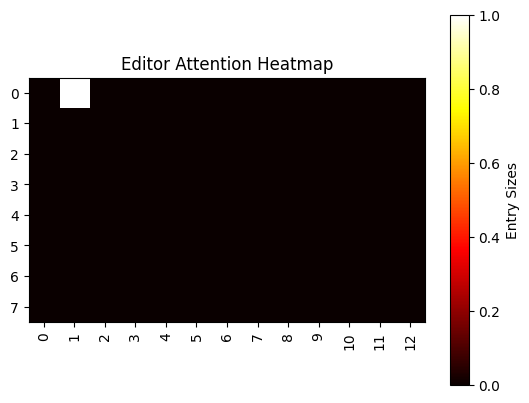

['Which', ' of', ' the', ' following', ' trade', ' agreements', ',', ' effective', ' January', ' 1', ',', ' 2022', ',', ' includes', ' countries', ' such', ' as', ' Australia', ',', ' China', ',', ' Japan', ',', ' and', ' New', ' Zealand', '?', '\n', '\n', 'A', '.', ' North', ' American', ' Free', ' Trade', ' Agreement', ' (', 'NA', 'F', 'TA', ')', '\n', 'B', '.', ' European', ' Union', ' Single', ' Market', '\n', 'C', '.', ' Trans', '-', 'Pacific', ' Partnership', ' (', 'TPP', ')', '\n', 'D', '.', ' Regional', ' Comprehensive', ' Economic', ' Partnership', ' (', 'R', 'CE', 'P', ')', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


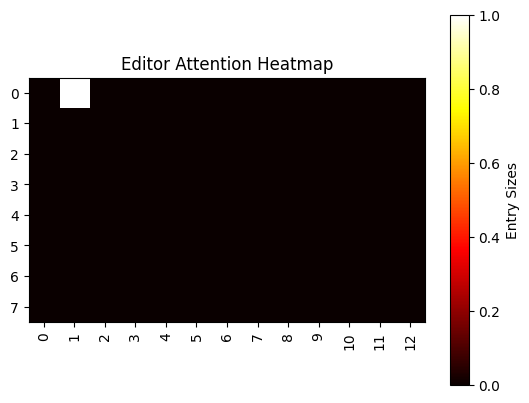

['Which', ' free', ' trade', ' area', ' came', ' into', ' effect', ' on', ' January', ' 1', ',', ' 2022', ',', ' for', ' several', ' countries', ' in', ' the', ' Asia', '-', 'Pacific', ' region', '?', '\n', '\n', 'A', ')', ' North', ' American', ' Free', ' Trade', ' Agreement', ' (', 'NA', 'F', 'TA', ')', '\n', 'B', ')', ' European', ' Union', ' (', 'EU', ')', '\n', 'C', ')', ' Regional', ' Comprehensive', ' Economic', ' Partnership', ' (', 'R', 'CE', 'P', ')', '\n', 'D', ')', ' Trans', '-', 'Pacific', ' Partnership', ' (', 'TPP', ')', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


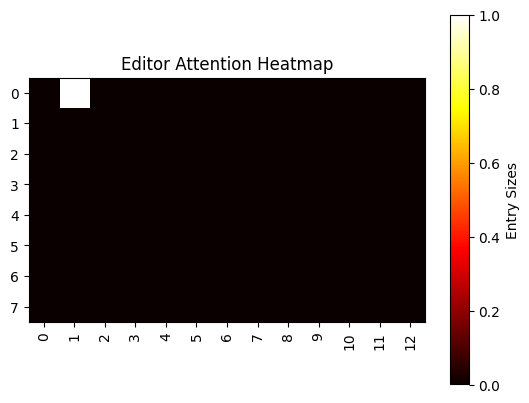

['What', ' is', ' the', ' significance', ' of', ' the', ' Regional', ' Comprehensive', ' Economic', ' Partnership', ' (', 'R', 'CE', 'P', ')', ' that', ' came', ' into', ' effect', ' on', ' January', ' 1', ',', ' 2022', '?', '\n', '\n', 'A', ')', ' It', ' is', ' the', ' smallest', ' free', ' trade', ' area', ' in', ' the', ' world', '\n', 'B', ')', ' It', ' only', ' includes', ' European', ' countries', '\n', 'C', ')', ' It', ' is', ' the', ' largest', ' free', ' trade', ' area', ' in', ' the', ' world', '\n', 'D', ')', ' It', ' is', ' focused', ' on', ' environmental', ' policies', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


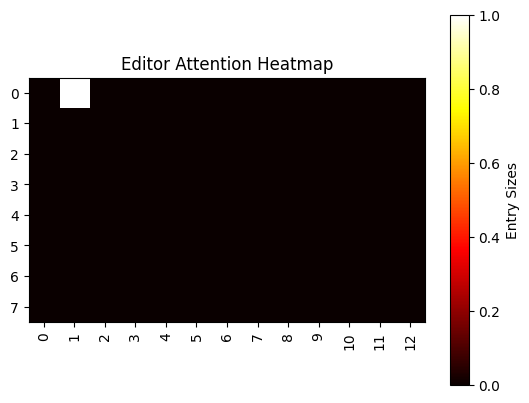

['Which', ' of', ' the', ' following', ' countries', ' is', ' NOT', ' a', ' member', ' of', ' the', ' Regional', ' Comprehensive', ' Economic', ' Partnership', ' (', 'R', 'CE', 'P', ')', ' that', ' came', ' into', ' effect', ' on', ' January', ' 1', ',', ' 2022', '?', '\n', '\n', 'A', ')', ' India', '\n', 'B', ')', ' China', '\n', 'C', ')', ' Japan', '\n', 'D', ')', ' Australia', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


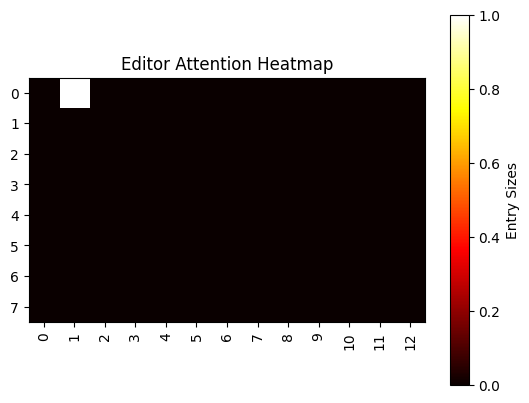

['Which', ' event', ' occurred', ' in', ' Sudan', ' on', ' January', ' 2', ',', ' 2022', ',', ' related', ' to', ' its', ' political', ' leadership', '?', '\n', '\n', 'A', '.', ' Omar', ' al', '-', 'B', 'ash', 'ir', ' returned', ' to', ' power', '\n', 'B', '.', ' Abd', 'alla', ' Ham', 'd', 'ok', ' resigned', ' as', ' Prime', ' Minister', '\n', 'C', '.', ' A', ' new', ' constitution', ' was', ' adopted', '\n', 'D', '.', ' Sudan', ' declared', ' a', ' state', ' of', ' emergency', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


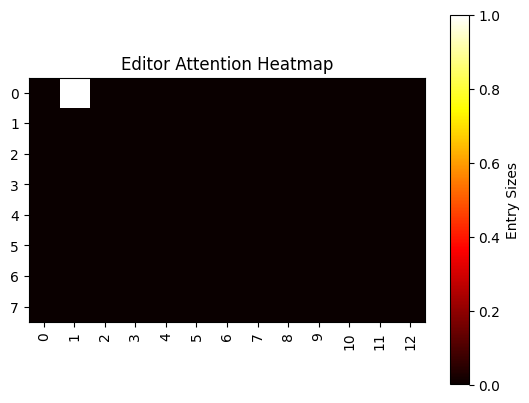

['Who', ' resigned', ' as', ' Prime', ' Minister', ' of', ' Sudan', ' on', ' January', ' 2', ',', ' 2022', '?', '\n', 'A', ')', ' Omar', ' al', '-', 'B', 'ash', 'ir', '\n', 'B', ')', ' Abd', 'alla', ' Ham', 'd', 'ok', '\n', 'C', ')', ' Sal', 'va', ' Ki', 'ir', ' May', 'ard', 'it', '\n', 'D', ')', ' Is', 'mail', ' al', '-', 'A', 'zh', 'ari', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


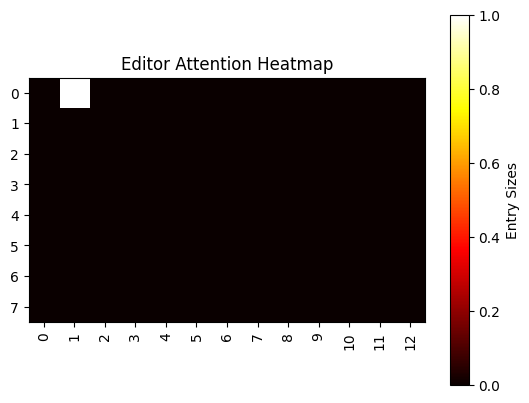

['What', ' event', ' led', ' to', ' the', ' resignation', ' of', ' Sudan', "'s", ' Prime', ' Minister', ' Abd', 'alla', ' Ham', 'd', 'ok', ' in', ' January', ' 2022', '?', '\n', 'A', ')', ' A', ' military', ' coup', '\n', 'B', ')', ' A', ' corruption', ' scandal', '\n', 'C', ')', ' Deadly', ' protests', '\n', 'D', ')', ' A', ' natural', ' disaster', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


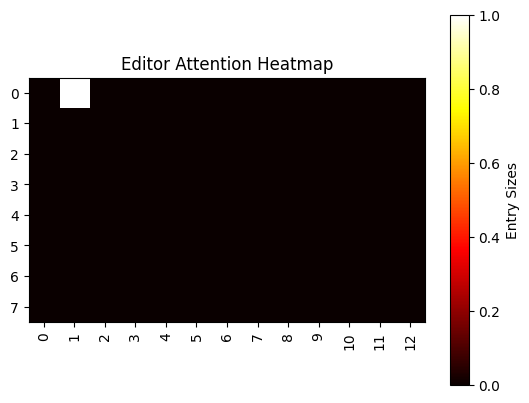

['On', ' what', ' date', ' did', ' Abd', 'alla', ' Ham', 'd', 'ok', ' resign', ' as', ' Prime', ' Minister', ' of', ' Sudan', '?', '\n', 'A', ')', ' December', ' 31', ',', ' 2021', '\n', 'B', ')', ' January', ' 1', ',', ' 2022', '\n', 'C', ')', ' January', ' 2', ',', ' 2022', '\n', 'D', ')', ' January', ' 3', ',', ' 2022', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!']


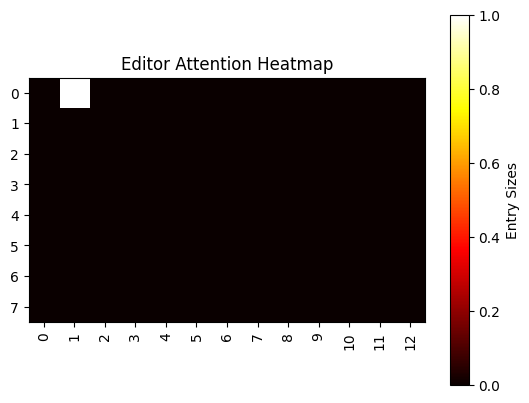

['Which', ' of', ' the', ' following', ' groups', ' of', ' countries', ' issued', ' a', ' joint', ' statement', ' on', ' January', ' 4', ',', ' 2022', ',', ' asserting', ' that', ' "', 'a', ' nuclear', ' war', ' cannot', ' be', ' won', ' and', ' must', ' never', ' be', ' fought', '"?', '\n', '\n', 'A', '.', ' Brazil', ',', ' India', ',', ' Germany', ',', ' Japan', ' and', ' South', ' Africa', '\n', 'B', '.', ' China', ',', ' France', ',', ' Russia', ',', ' the', ' United', ' Kingdom', ' and', ' the', ' United', ' States', '\n', 'C', '.', ' Canada', ',', ' Mexico', ',', ' Egypt', ',', ' South', ' Korea', ' and', ' Turkey', '\n', 'D', '.', ' Australia', ',', ' Italy', ',', ' Spain', ',', ' Sweden', ' and', ' Switzerland', '!']


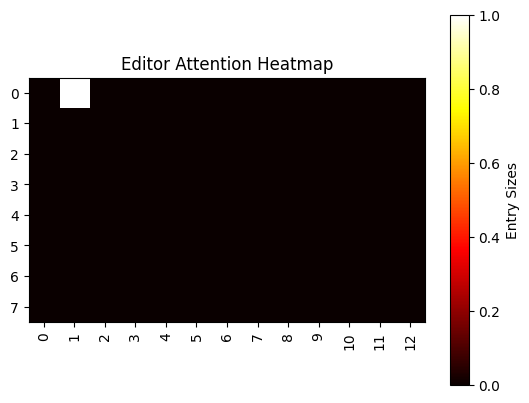

['On', ' January', ' 4', ',', ' 2022', ',', ' which', ' five', ' countries', ' issued', ' a', ' joint', ' statement', ' aff', 'irming', ' that', ' "', 'a', ' nuclear', ' war', ' cannot', ' be', ' won', ' and', ' must', ' never', ' be', ' fought', '"?', '\n', '\n', 'A', '.', ' United', ' States', ',', ' Russia', ',', ' China', ',', ' India', ',', ' and', ' Brazil', '\n', 'B', '.', ' Germany', ',', ' Japan', ',', ' Italy', ',', ' Canada', ',', ' and', ' Australia', '\n', 'C', '.', ' China', ',', ' France', ',', ' Russia', ',', ' the', ' United', ' Kingdom', ',', ' and', ' the', ' United', ' States', '\n', 'D', '.', ' Brazil', ',', ' South', ' Africa', ',', ' India', ',', ' China', ',', ' and', ' Russia']


In [30]:
import matplotlib.pyplot as plt
import numpy as np
stopping_index = 8

for batch_index in range(len(batch["edit_tokens"])):

    # Reshape the tensor into an 8x13 matrix
    attention_matrix = result["editor_attention"][batch_index].reshape(8, 13).to("cpu")

    # is this any better??
    # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

    # Detach and convert to numpy
    attention_matrix = attention_matrix.detach().numpy()

    # Create the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(attention_matrix, cmap="hot")

    # Color the heatmap according to the entry sizes
    heatmap.set_clim(vmin=np.min(attention_matrix), vmax=np.max(attention_matrix))
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Entry Sizes")

    # Add labels to the x and y axes
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(13))
    ax.set_yticklabels(np.arange(8))

    # Rotate the x-axis labels
    plt.xticks(rotation=90)

    # Add a title
    plt.title("Editor Attention Heatmap")

    # Show the plot
    plt.show()


    print(tokenizer.batch_decode(batch["question_tokens"][batch_index]))

In [31]:
# torch.norm(
#     result["edit_vectors"][batch_index][:stopping_index, :, :].to("cpu"), dim=[0, 2]
# )  # looks better now!

Notes: It seems, currently, like we are not giving sufficient incentive to intervene at the lowest possible layer

In [32]:
result["edit_vectors"].shape

torch.Size([10, 88, 13, 768])

In [33]:
edit_tensor = result["edit_vectors"][batch_index].reshape(8, 13, -1).to("cpu")
edit_tensor_norm = edit_tensor.norm(dim=2)
edit_tensor_norm.shape

torch.Size([8, 13])

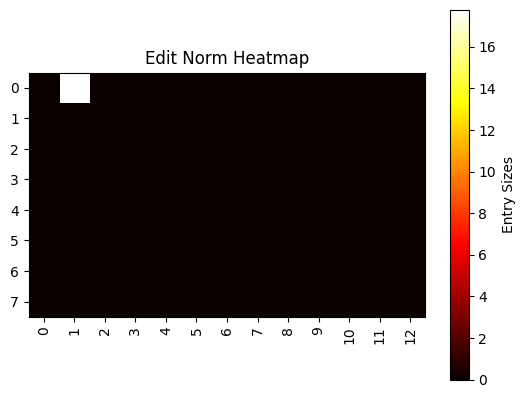

['Which', ' of', ' the', ' following', ' trade', ' agreements', ',', ' effective']


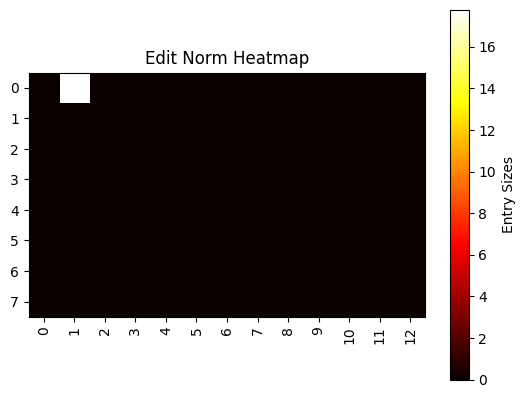

['Which', ' free', ' trade', ' area', ' came', ' into', ' effect', ' on']


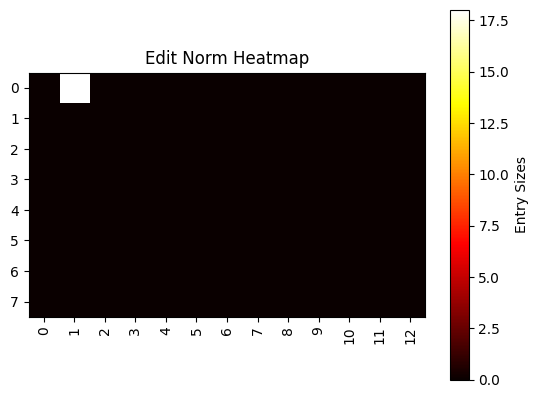

['What', ' is', ' the', ' significance', ' of', ' the', ' Regional', ' Comprehensive']


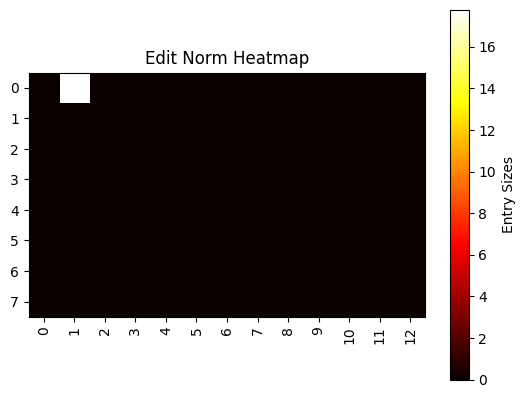

['Which', ' of', ' the', ' following', ' countries', ' is', ' NOT', ' a']


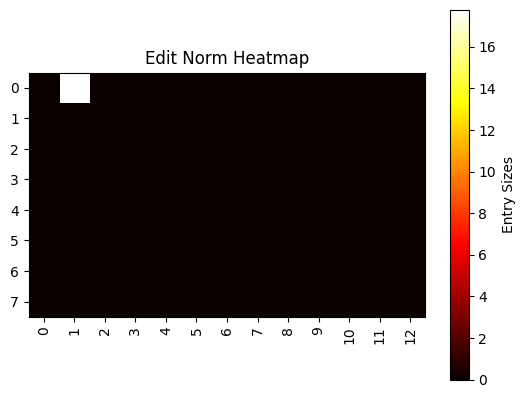

['Which', ' event', ' occurred', ' in', ' Sudan', ' on', ' January', ' 2']


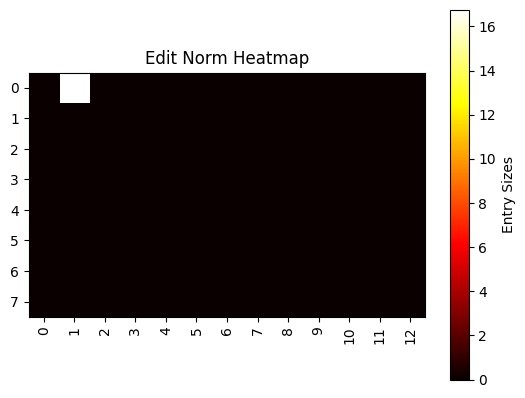

['Who', ' resigned', ' as', ' Prime', ' Minister', ' of', ' Sudan', ' on']


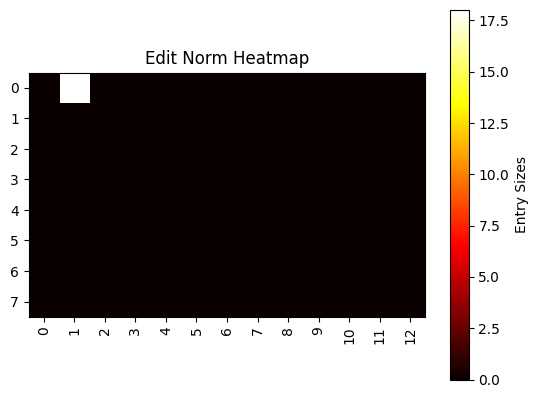

['What', ' event', ' led', ' to', ' the', ' resignation', ' of', ' Sudan']


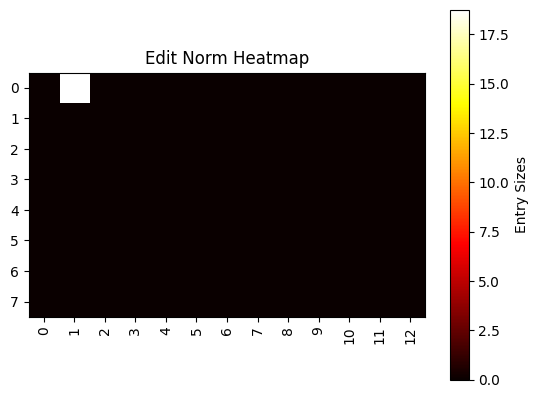

['On', ' what', ' date', ' did', ' Abd', 'alla', ' Ham', 'd']


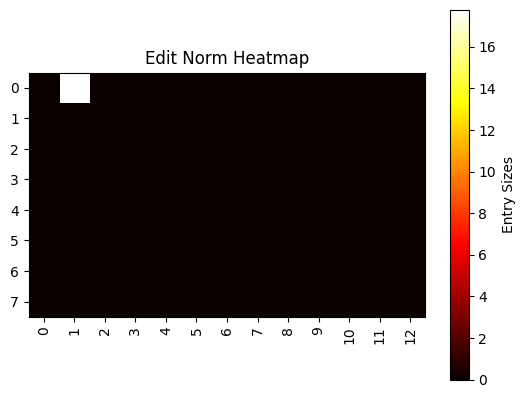

['Which', ' of', ' the', ' following', ' groups', ' of', ' countries', ' issued']


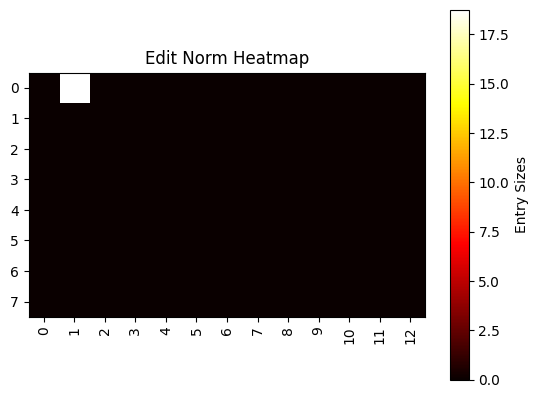

['On', ' January', ' 4', ',', ' 2022', ',', ' which', ' five']


In [34]:
for batch_index in range(len(batch["edit_tokens"])):

    #The tensor norm comes in an 8x13 matrix
    edit_tensor = result["edit_vectors"][batch_index].to("cpu")
    edit_tensor_norm = edit_tensor.norm(dim=2)

    # is this any better??
    # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

    # Detach and convert to numpy
    edit_tensor_norm = edit_tensor_norm.detach().numpy()[0:stopping_index, :]

    # Create the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(edit_tensor_norm, cmap="hot")

    # Color the heatmap according to the entry sizes
    heatmap.set_clim(vmin=np.min(0), vmax=np.max(edit_tensor_norm))
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Entry Sizes")

    # Add labels to the x and y axes
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(13))
    ax.set_yticklabels(np.arange(8))

    # Rotate the x-axis labels
    plt.xticks(rotation=90)

    # Add a title
    plt.title("Edit Norm Heatmap")

    # Show the plot
    plt.show()

    print(tokenizer.batch_decode(batch["question_tokens"][batch_index][0:8]))

In [35]:
edited_states = torch.stack(result['edited_hidden_states'],dim = 2)
edited_states.shape

torch.Size([10, 88, 13, 768])

In [36]:
for i in range(8):
    print(edited_states[0][i][0].norm())

tensor(10.4767, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.7730, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.3021, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.3593, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.4256, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.4459, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.0398, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.1384, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [37]:
# # Some basic checks of embedding norms 

# # Access the embedding layer
# embeddings = model.get_input_embeddings()

# # Get the weight matrix of the embeddings
# embedding_weights = embeddings.weight

# # Calculate the L2 norm for each embedding vector
# norms = torch.norm(embedding_weights, p=2, dim=1)

# # Iterate over each token in the tokenizer to display its norm
# token_norms = {}
# for token, index in tokenizer.get_vocab().items():
#     token_norms[token] = norms[index].item()

# # Example output for a few tokens
# # for token, norm in list(token_norms.items())[:100]:  # Displaying the first 10 for brevity
# #     print(f"Token: {token}, Norm: {norm}")

# print(embedding_weights.shape)

# print(token_norms)

# #plt.hist(list(token_norms.values()), bins=100)

# # Access the positional embedding layer
# positional_embeddings = model.transformer.wpe.weight  # For GPT-2, positional embeddings are accessed via `wpe` attribute

# print(positional_embeddings.shape)

# # Calculate the L2 norm for each positional embedding vector
# positional_norms = torch.norm(positional_embeddings, p=2, dim=1)

# print(torch.min(positional_norms), torch.max(positional_norms))

# # Print the norms of the first few positional embeddings
# for position, norm in enumerate(positional_norms[:10]):  # Displaying the first 10 for brevity
#     plt.hist(list(positional_norms.to('cpu').detach().numpy()), bins=100)


In [38]:
print(
    torch.norm(result['target_hidden_states'][0][6][0]),
    torch.norm(result['target_hidden_states'][0][0][0]),
    edited_states[0][6][0].norm(),
    edited_states[0][2][0].norm()
)


tensor(5.0398, device='cuda:0') tensor(10.4767, device='cuda:0') tensor(5.0398, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(5.3021, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [39]:
# tempdata = torch.tensor(dataset['edit_result_ids'][0:1])
# tempdata[:, :stop_editing_index][tempdata[:, :stop_editing_index] == 3797] = 3290
# with torch.no_grad():
#     logits = model(tempdata).logits
#     predictions = torch.nn.functional.softmax(logits, dim=2)
#     temp_output = predictions[:, stop_editing_index:, :].reshape(-1, 50257)
# error = temp_output - nn.functional.softmax(test_output['logits'],dim=2)[0,stop_editing_index:,:]
# torch.max(error)

In [40]:
# torch.save(hypernetwork.state_dict(), "/root/aiplay-1/hypernetworks/hypernetwork.pth")